In [1]:
import os
import functools

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from itertools import combinations

import tensorflow as tf
from tensorflow.python.keras import backend as K

In [2]:
from Segmentation.optimizer.solver_encoder_decoder import Solver
from Segmentation.architecture.unet import Unet #Optional. Use encode-decoder approach
from Segmentation.preprocess.preprocess import Data_Preprocess
from Segmentation.assistant import assistant
import Segmentation.visualization.vis_utils as vis

Using TensorFlow backend.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
dirname = os.getcwd()
dataset_path = os.path.join( dirname , "DATA/dataset")
train_path = os.path.join(dataset_path , "training")
test_path = os.path.join( dataset_path , "testing")
csv_path = os.path.join( dataset_path , "train.txt")



In [5]:
test = Data_Preprocess(dataset_path = dataset_path
                       ,train_path = train_path
                       ,test_path = test_path
                       ,image_shape = (64, 64, 3)
                       ,batch_size = 1
                       ,csv_path = csv_path
                       )

In [6]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = test.get_train_val_split_paths()

Number of training examples: 303
Number of validation examples: 76


## Visualize random pairs
 

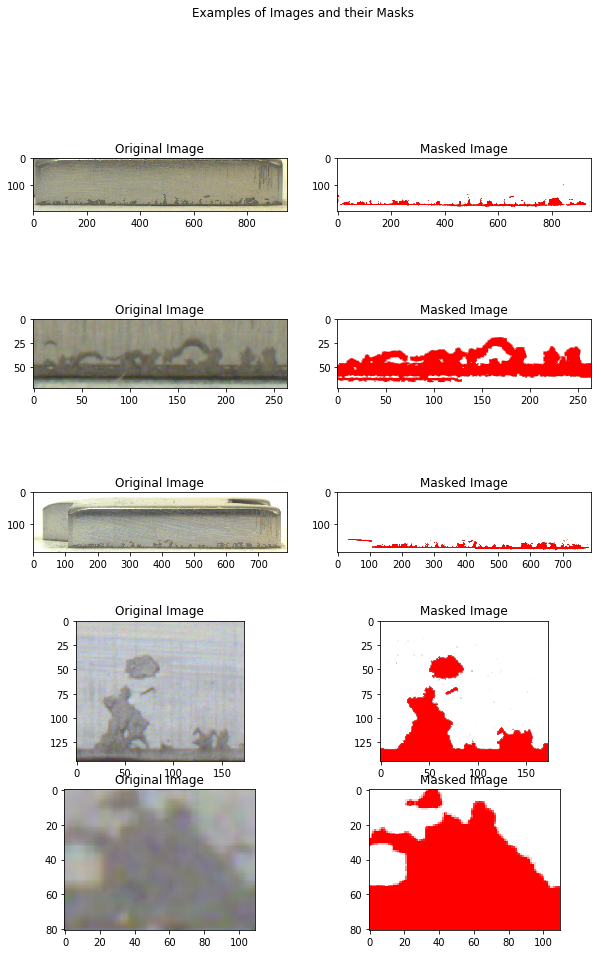

In [7]:
vis.visualize_pairs(x_train_filenames,y_train_filenames,num = 5 )

## Set up some parameters
### For better perfomance it's desirable to use number of epochs > 200 and batch_size <=3  

In [8]:
img_shape = (64, 64, 3)  #(256, 256, 3)
batch_size = 10 #3
epochs = 1

# Build our input pipeline with `tf.data`


## Set up train and validation datasets
Note that we apply image augmentation to our training dataset but not our validation dataset. 

In [9]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(test._augment, **tr_cfg)

In [10]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(test._augment, **val_cfg)

In [11]:
train_ds = test.get_baseline_dataset(x_train_filenames,
                                     y_train_filenames,
                                     preproc_fn=tr_preprocessing_fn,
                                    )
val_ds = test.get_baseline_dataset(x_val_filenames,
                                   y_val_filenames, 
                                   preproc_fn=val_preprocessing_fn,
                                  )

## Let's see if our image augmentor data pipeline is producing expected results

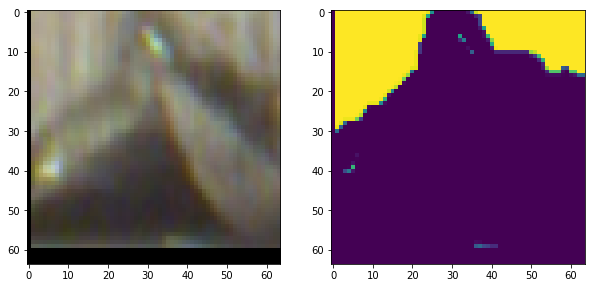

In [12]:
temp_ds = test.get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  #plt.imshow(label[0, :, :, 0])
  plt.imshow(label[0, :, :, 0])
  plt.show()

# Build the model

## The Keras Functional API


## Train your model
Training your model with `tf.data` involves simply providing the model's `fit` function with your training/validation dataset, the number of steps, and epochs.  

We also include a Model callback, [`ModelCheckpoint`](https://keras.io/callbacks/#modelcheckpoint) that will save the model to disk after each epoch. We configure it such that it only saves our highest performing model. Note that saving the model capture more than just the weights of the model: by default, it saves the model architecture, weights, as well as information about the training process such as the state of the optimizer, etc.

In [13]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

In [14]:
optim_config = {
                    'lr': 1e-5,
                    'decay': 0.9,
                    'rho': 0.9,
                    'epsilon': 1e-10
                }
params = {  'num_train_examples' : num_train_examples
            ,'num_val_examples' : num_val_examples
            ,'batch_size' : batch_size
            ,'num_epochs' : epochs
            ,'loss' : 'bce_dice_loss'
            ,'optimizer' : 'rms'
            ,'optimizer_config' : optim_config
            ,'metrics' : ['dice_loss','f1','recall','precision']
            ,'save_model_path' : os.path.join(os.getcwd(),'weights.hdf5')
            ,'verbose' : True
         }
assis = assistant(train_ds, val_ds, **params)
history = assis.run_training()

Here Loss
Encoder (<tf.Tensor 'activation_11/Relu:0' shape=(?, 2, 2, 1024) dtype=float32>, [<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 32, 32, 32) dtype=float32>, <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 16, 16, 64) dtype=float32>, <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 8, 8, 128) dtype=float32>, <tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(?, 4, 4, 256) dtype=float32>, <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(?, 2, 2, 512) dtype=float32>], [<tf.Tensor 'activation_1/Relu:0' shape=(?, 64, 64, 32) dtype=float32>, <tf.Tensor 'activation_3/Relu:0' shape=(?, 32, 32, 64) dtype=float32>, <tf.Tensor 'activation_5/Relu:0' shape=(?, 16, 16, 128) dtype=float32>, <tf.Tensor 'activation_7/Relu:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'activation_9/Relu:0' shape=(?, 4, 4, 512) dtype=float32>], <tf.Tensor 'input_1:0' shape=(?, 64, 64, 3) dtype=float32>)
Here+++++++++++++++++++++++++++++=
Begin
Epoch 1/1
29/30 [============================>.] - ETA: 0s - loss: 1.1

# Old version of training. Used whole Unet architecture: without encoder decoder spliter

model = Unet()
#model.build_model()

optim_config = {
                    'lr': 1e-5,
                    'decay': 0.9,
                    'rho': 0.9,
                    'epsilon': 1e-10
                }

solver = Solver(model.build_model()
                ,train_ds, val_ds
                ,num_train_examples = num_train_examples
                ,num_val_examples = num_val_examples
                ,batch_size = 2
                ,num_epochs = epochs
                ,loss = 'bce_dice_loss'
                ,optimizer = 'rms'
                ,optimizer_config = optim_config
                ,metrics = ['dice_loss','f1','recall','precision']
                ,save_model_path = os.path.join(os.getcwd(),'weights.hdf5')
                ,verbose = True
               )
history = solver.train()


# Visualize training process

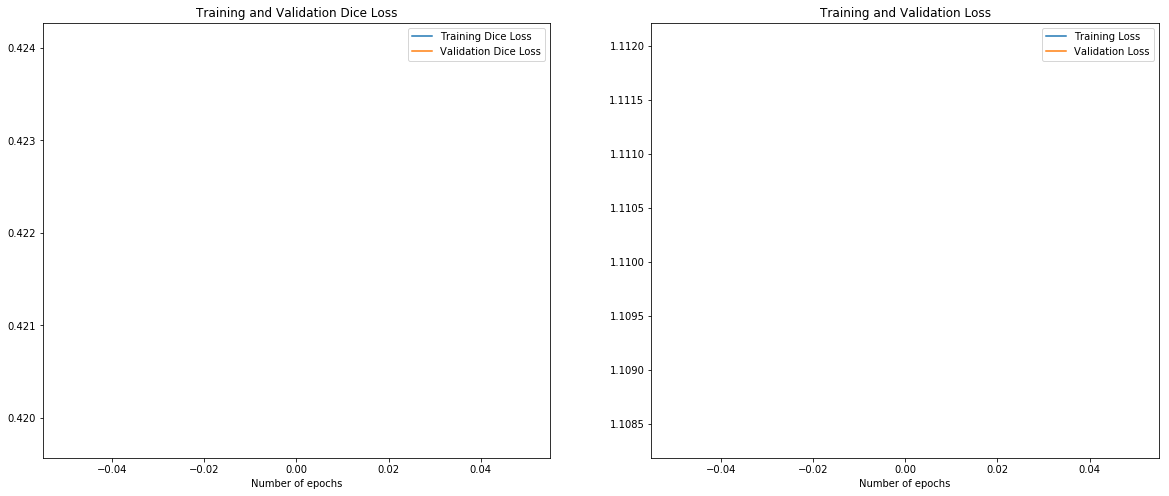

In [15]:
train_dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.xlabel("Number of epochs")
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Number of epochs")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

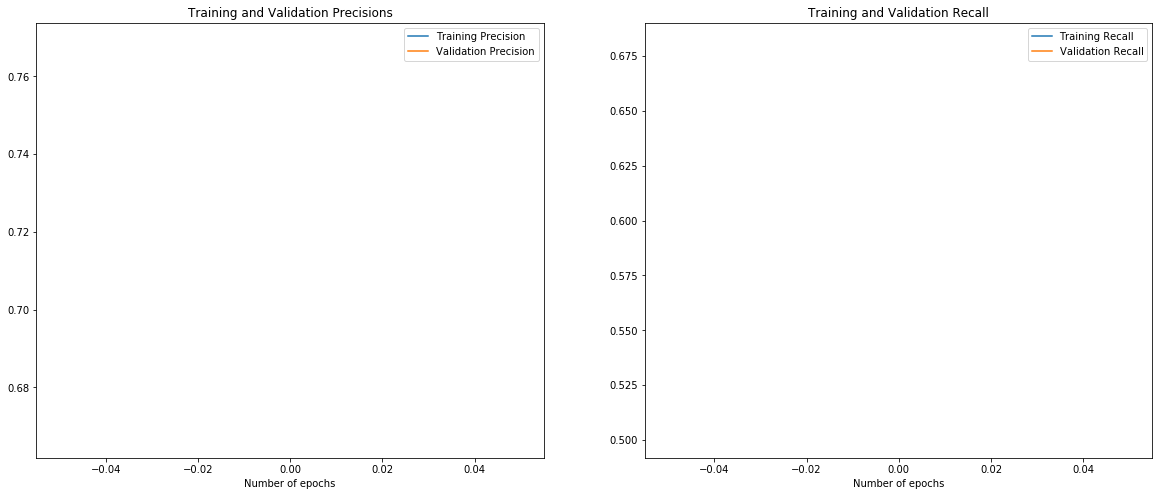

In [16]:
train_recall = history.history['recall']
val_recall   = history.history['val_recall']

train_precision = history.history['precision']
val_precision   = history.history['val_precision']

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_precision, label='Training Precision')
plt.plot(epochs_range, val_precision, label='Validation Precision')
plt.xlabel("Number of epochs")
plt.legend(loc='upper right')
plt.title('Training and Validation Precisions')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.xlabel("Number of epochs")
plt.legend(loc='upper right')
plt.title('Training and Validation Recall')


plt.show()



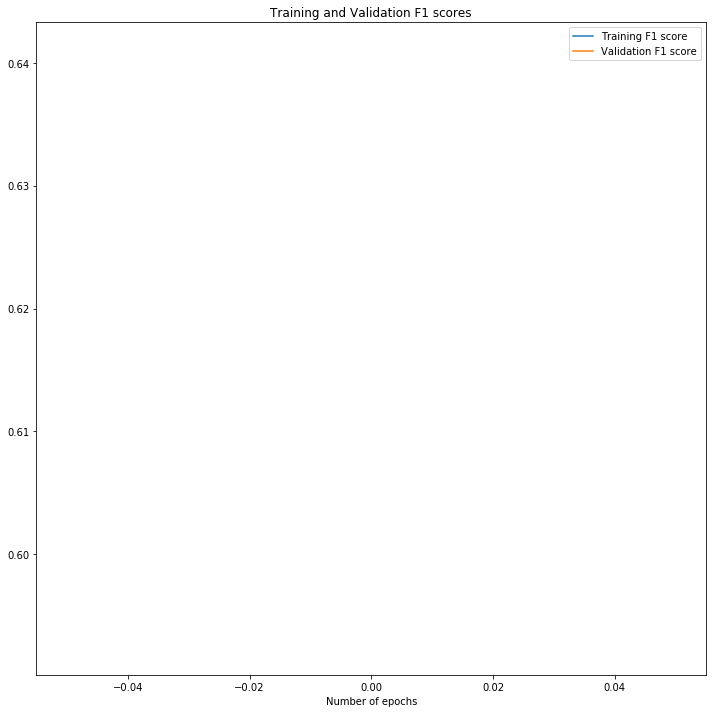

In [17]:
train_f1 = history.history['F1']
val_f1   = history.history['val_F1']

plt.subplot(1, 1, 1)
plt.plot(epochs_range, train_f1, label='Training F1 score')
plt.plot(epochs_range, val_f1, label='Validation F1 score')
plt.legend(loc='upper right')
plt.xlabel("Number of epochs")
plt.title('Training and Validation F1 scores')

plt.show()

# Visualize actual performance 


In [18]:
assis.decoder

Before
After
In


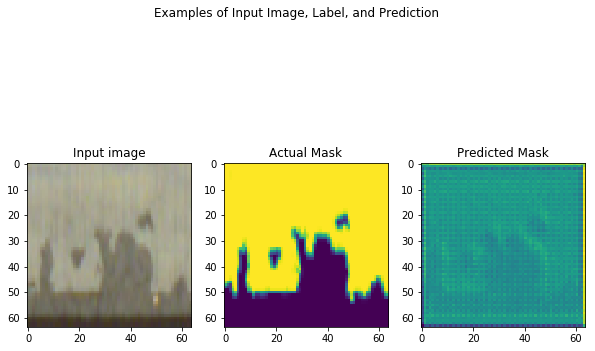

In [21]:
# Let's visualize some of the outputs 
vis.visualize_result_triples(assis,assis.weights_path,val_ds)